In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from statsmodels.tsa.api import Holt
import math

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR


In [2]:
df = pd.read_csv('saas.csv')
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [3]:
pd.concat([df.head(3), df.tail(3)])

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0
790457,2017-12-31,1029399,5790457,0.0,0.0


In [4]:
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)

In [5]:
df.dtypes

Month_Invoiced       datetime64[ns]
Customer_Id                   int64
Invoice_Id                    int64
Subscription_Type           float64
Amount                      float64
dtype: object

In [6]:
df.set_index(df.Month_Invoiced, inplace=True)
df.drop(columns='Month_Invoiced', inplace=True)

In [7]:
pd.concat([df.head(3), df.tail(3)])

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2017-12-31,1029397,5790455,3.0,15.0
2017-12-31,1029398,5790456,0.0,0.0
2017-12-31,1029399,5790457,0.0,0.0


### Split data (train/test) and resample by any period except daily, and aggregate using the sum.

In [8]:
resamped_data = df.Amount.resample('M').agg('sum')

In [9]:
whole_length = len(resamped_data)
train_length = int(whole_length * 0.7)

In [10]:
train = resamped_data[0:train_length]
test = resamped_data[train_length:whole_length]

In [11]:
print(train.shape)
print(test.shape)

(33,)
(15,)


In [12]:
33 + 15

48

In [13]:
48/12

4.0

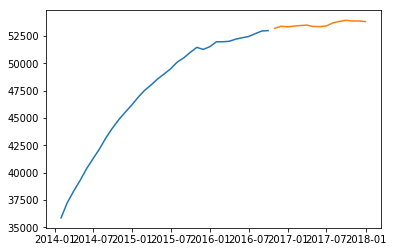

In [14]:
plt.plot(train)
plt.plot(test)
plt.show()

In [15]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

### Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- simple average
- moving average
- Holt's linear trend model
- Based on previous year/month/etc (your choice)

##### Simple average

In [16]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat.head()

,actual,avg_forecast
Month_Invoiced,,
2016-10-31,53190.0,47427.727273
2016-11-30,53375.0,47427.727273
2016-12-31,53320.0,47427.727273
2017-01-31,53395.0,47427.727273
2017-02-28,53440.0,47427.727273


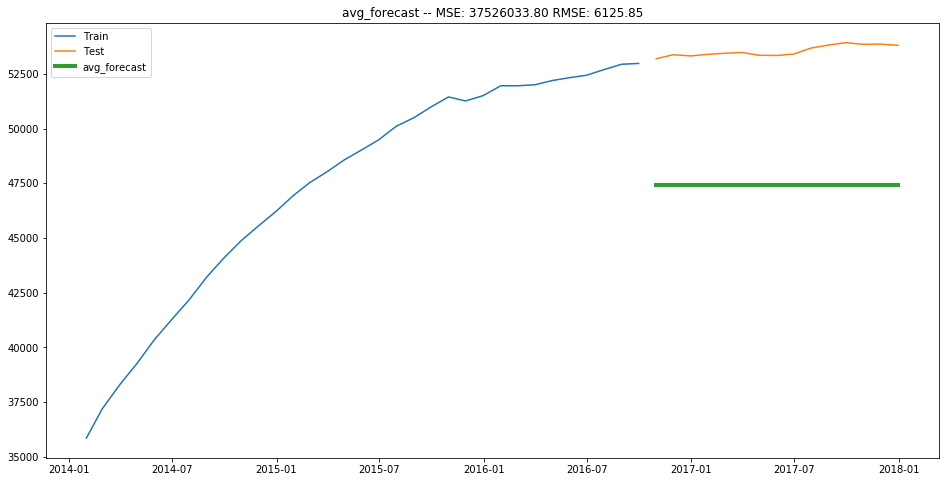

In [17]:
plot_and_eval(yhat.avg_forecast)

##### Moving average

In [18]:
periods = 3
yhat['moving_avg_forecast_3'] = train.rolling(periods).mean().iloc[-1]
yhat.head()

,actual,avg_forecast,moving_avg_forecast_3
Month_Invoiced,,,
2016-10-31,53190.0,47427.727273,52870.0
2016-11-30,53375.0,47427.727273,52870.0
2016-12-31,53320.0,47427.727273,52870.0
2017-01-31,53395.0,47427.727273,52870.0
2017-02-28,53440.0,47427.727273,52870.0


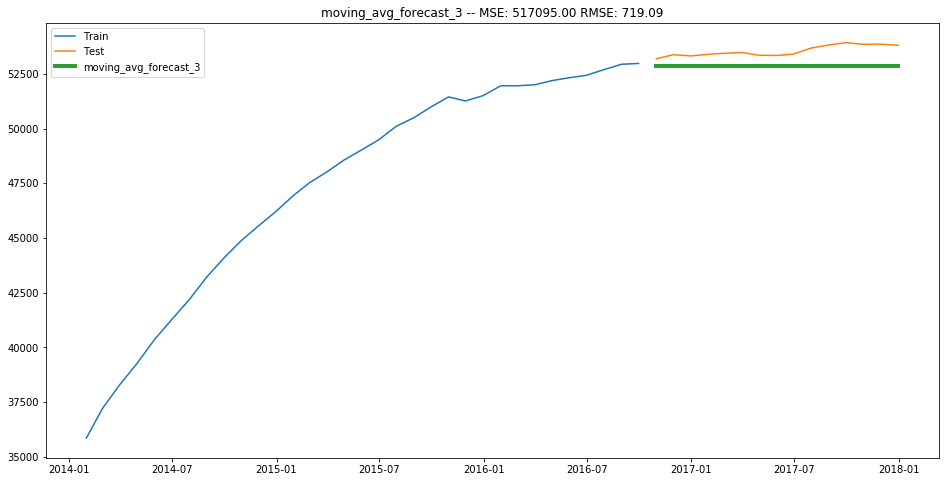

In [19]:
plot_and_eval(yhat.moving_avg_forecast_3)

##### Holt's linear trend model

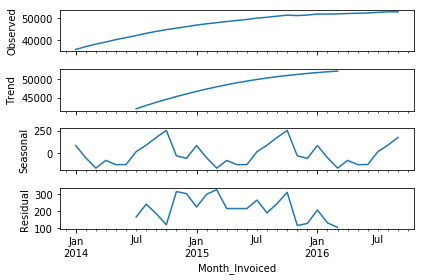

In [20]:
sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

Doesn't really seem seasonal to me.

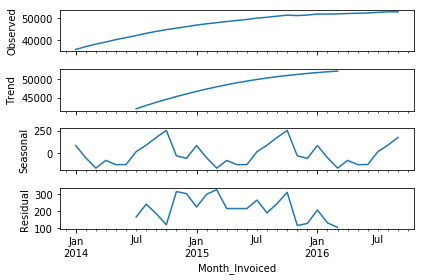

Month_Invoiced
2016-10-31    53190.0
2016-11-30    53375.0
2016-12-31    53320.0
2017-01-31    53395.0
2017-02-28    53440.0
2017-03-31    53480.0
2017-04-30    53350.0
2017-05-31    53340.0
2017-06-30    53405.0
2017-07-31    53680.0
2017-08-31    53820.0
2017-09-30    53925.0
2017-10-31    53850.0
2017-11-30    53860.0
2017-12-31    53805.0
Freq: M, Name: Amount, dtype: float64

In [21]:
# train = df[:'2016'].Amount.resample('M').agg('sum')
# test = df['2017':].Amount.resample('M').agg('sum')

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

Holt(train).fit(smoothing_level=.9, smoothing_slope=.1).forecast(test.shape[0])

yhat['holt_linear'] = Holt(train).fit(smoothing_level=.9, smoothing_slope=.1).forecast(test.shape[0])
test

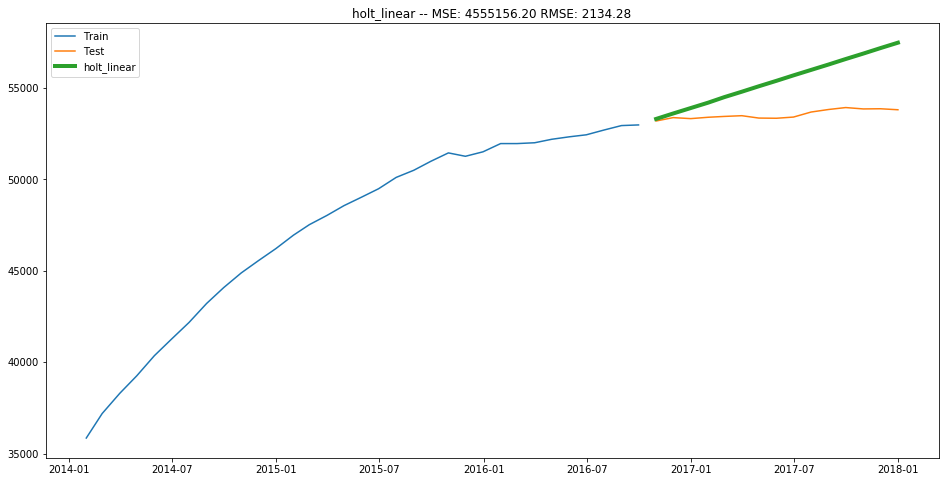

In [22]:
plot_and_eval(yhat.holt_linear)

In [23]:
# using_last_year = train['2016']\
#     .reset_index()\
#     .drop(columns='Amount')\
#     .set_index(train['2016'].index + 366)\
#     .iloc[:-1]

In [24]:
train = df[:'2016'].Amount.resample('M').agg('sum')
test = df['2017':].Amount.resample('M').agg('sum')

yhat = pd.DataFrame(dict(actual=test))

In [25]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

In [26]:
using_last_year = train['2016'].reset_index().drop(columns='Month_Invoiced').set_index(train['2016'].index + 12)

In [27]:
yhat['last_year'] = using_last_year

In [28]:
yhat

,actual,last_year
Month_Invoiced,,
2017-01-31,53395.0,51955.0
2017-02-28,53440.0,51955.0
2017-03-31,53480.0,52000.0
2017-04-30,53350.0,52190.0
2017-05-31,53340.0,52325.0
2017-06-30,53405.0,52435.0
2017-07-31,53680.0,52695.0
2017-08-31,53820.0,52940.0
2017-09-30,53925.0,52975.0


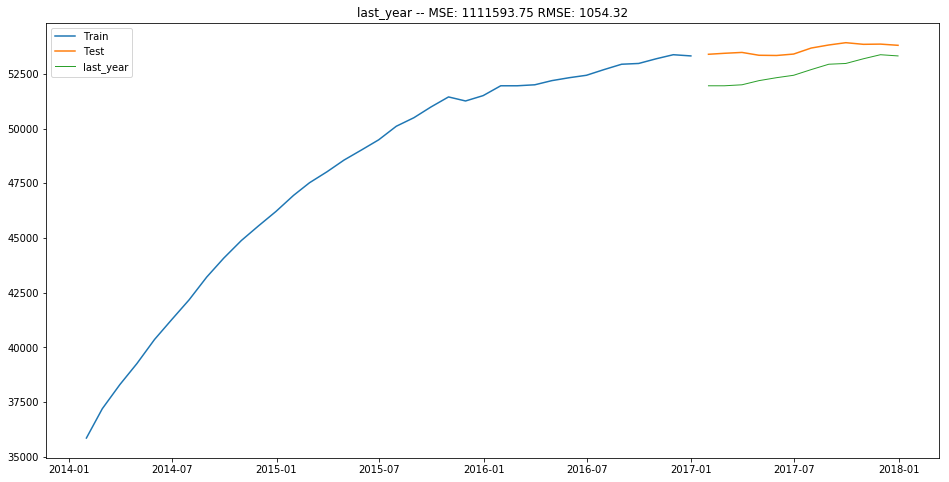

In [29]:
plot_and_eval(yhat.last_year, linewidth=1)

In [30]:
predictions = train['2016'] + train.diff(12).mean()

In [31]:
predictions.index = pd.date_range('20170101', periods=12, freq='M')

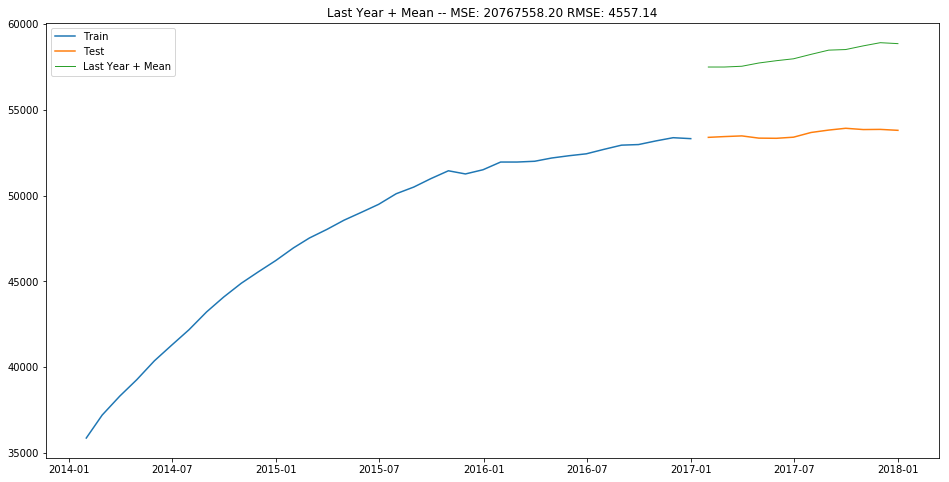

In [32]:
predictions = predictions
predictions.name = 'Last Year + Mean'

plot_and_eval(predictions, linewidth=1)

# Prophet

In [33]:
from fbprophet import Prophet

In [34]:
stores = pd.read_csv('stores.csv', sep='\t', index_col=False)
items = pd.read_csv('items.csv', sep='\t', index_col=False)
sales = pd.read_csv('sales.csv', sep='\t', index_col=False)

In [35]:
items_sales = pd.merge(items, sales, left_on='item_id', right_on='item')
shopping_df = pd.merge(items_sales, stores, left_on='store', right_on='store_id')
shopping_df.drop(['item', 'store', 'Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)
shopping_df.head()

,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,sale_amount,sale_date,sale_id,store_address,store_city,store_id,store_state,store_zipcode
0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
1,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
2,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
3,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
4,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253


### Predict 2018 total monthly sales for a single store and/or item by creating a model using prophet

In [36]:
heb = shopping_df.loc[shopping_df.store_id == 2]
heb = heb.loc[heb.item_name == 'Pizza Sauce']
heb.shape

(1826, 14)

In [37]:
heb['ds'] = pd.to_datetime(heb.sale_date)
heb['y'] = heb.sale_amount * heb.item_price
heb.set_index(heb.ds, inplace=True)

In [38]:
heb.head()

,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,sale_amount,sale_date,sale_id,store_address,store_city,store_id,store_state,store_zipcode,ds,y
ds,,,,,,,,,,,,,,,,
2013-01-01,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,43.0,"Tue, 01 Jan 2013 00:00:00 GMT",823527,9255 FM 471 West,San Antonio,2,TX,78251,2013-01-01,199.95
2013-01-02,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,52.0,"Wed, 02 Jan 2013 00:00:00 GMT",823528,9255 FM 471 West,San Antonio,2,TX,78251,2013-01-02,241.80
2013-01-03,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,30.0,"Thu, 03 Jan 2013 00:00:00 GMT",823529,9255 FM 471 West,San Antonio,2,TX,78251,2013-01-03,139.50
2013-01-04,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,46.0,"Fri, 04 Jan 2013 00:00:00 GMT",823530,9255 FM 471 West,San Antonio,2,TX,78251,2013-01-04,213.90
2013-01-05,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664,41.0,"Sat, 05 Jan 2013 00:00:00 GMT",823531,9255 FM 471 West,San Antonio,2,TX,78251,2013-01-05,190.65


In [39]:
heb.drop(columns='sale_date', inplace=True)

In [40]:
df = heb.y.resample('M').agg('sum').reset_index()

In [72]:
df.head()

,ds,y,cap,floor
0,2013-01-31,6100.80,18000,6000
1,2013-02-28,6342.60,18000,6000
2,2013-03-31,8393.25,18000,6000
3,2013-04-30,9230.25,18000,6000
4,2013-05-31,10555.50,18000,6000


In [41]:
# df = heb.groupby('ds')['y'].sum().reset_index()

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


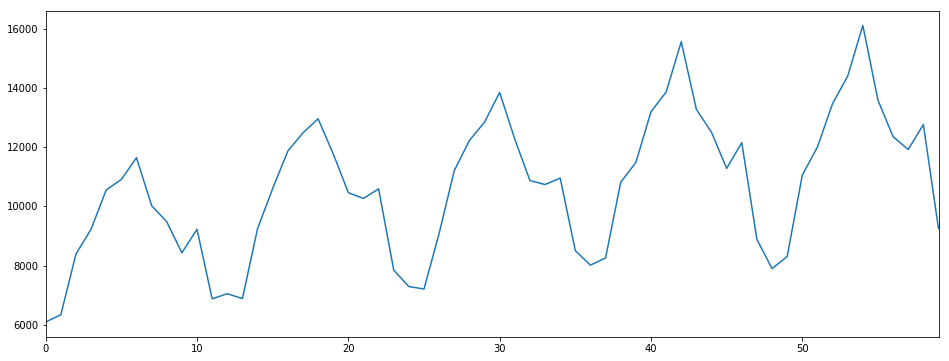

In [42]:
plt.figure(figsize=(16,6))
sns.tsplot(df.y)

In [55]:
df['cap'] = 18000
df['floor'] = 6000

m = Prophet(growth='logistic', changepoint_range=0.9)
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [65]:
future = m.make_future_dataframe(periods=12, freq='M')
future['cap'] = 18000
future['floor'] = 6000

print(future.head())
print(future.tail())
print(df.tail())

          ds    cap  floor
0 2013-01-31  18000   6000
1 2013-02-28  18000   6000
2 2013-03-31  18000   6000
3 2013-04-30  18000   6000
4 2013-05-31  18000   6000
           ds    cap  floor
67 2018-08-31  18000   6000
68 2018-09-30  18000   6000
69 2018-10-31  18000   6000
70 2018-11-30  18000   6000
71 2018-12-31  18000   6000
           ds         y    cap  floor
55 2017-08-31  13582.65  18000   6000
56 2017-09-30  12350.40  18000   6000
57 2017-10-31  11917.95  18000   6000
58 2017-11-30  12759.60  18000   6000
59 2017-12-31   9253.50  18000   6000


### Return a data frame with the month, storeid, yhat, and the confidence intervals (yhat lower, yhat upper)

In [66]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
67,2018-08-31,14551.817623,14096.012816,15006.868098
68,2018-09-30,13280.513481,12824.660540,13761.229717
69,2018-10-31,12957.382754,12530.375668,13468.674085
70,2018-11-30,13338.995408,12860.143933,13798.151837
71,2018-12-31,10680.053319,10206.132091,11133.091444


### Plot the 2018 monthly sales predictions

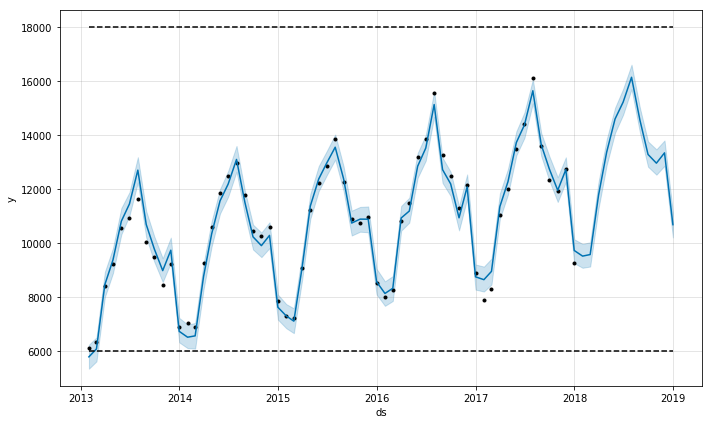

In [67]:
fig1 = m.plot(forecast);

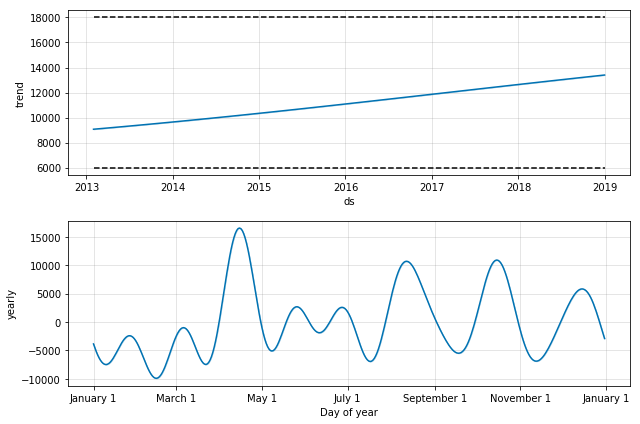

In [68]:
m.plot_components(forecast);

In [82]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='180 days')


df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 12 forecasts with cutoffs between 2014-10-18 00:00:00 and 2017-07-04 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 17.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.


,horizon,mse,rmse,mae,mape,coverage
30,20 days,9.830361e+06,3135.340645,2989.951677,0.288523,0.142857
42,22 days,9.679332e+06,3111.162418,2962.119967,0.273441,0.285714
48,24 days,1.022022e+07,3196.907970,3038.681083,0.279953,0.285714
60,25 days,1.011283e+07,3180.067364,2968.202092,0.266335,0.285714
54,26 days,9.406875e+06,3067.062941,2816.504829,0.269318,0.142857


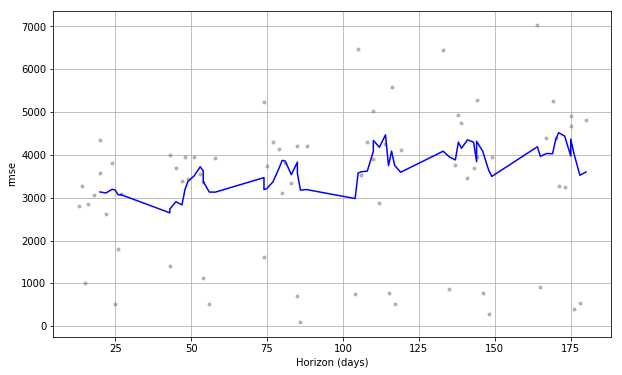

In [83]:
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

# plot_forecast_component(m, forecast, 'yhat')

plot_cross_validation_metric(df_cv, metric='rmse');